In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('qdrops.csv', parse_dates=True)

df = df.sort_values(by='drop_id')
# df = df.set_index('drop_id')

# df['hour'] = pd.to_datetime(df.date).dt.hour
# df['hour_utc'] = pd.to_datetime(df.date).dt.tz_convert("UTC").dt.hour
# df['time_utc'] = pd.to_datetime(df.date).dt.tz_convert("UTC").dt.time
# df['weekday'] = pd.to_datetime(df.date).dt.dayofweek

df['date'] = pd.to_datetime(df.date)

# # Update: Use fractional hours
# df['hour_utc'] += df.date.dt.minute / 60
# df['hour'] += df.date.dt.minute / 60

# df['minutes_since_last_drop'] = pd.to_datetime(df.date).diff().dt.total_seconds() / 60
# df['minutes_since_last_drop'] = df.minutes_since_last_drop.replace(0, 0.05)
# df['minutes_since_last_drop_avg'] = df.minutes_since_last_drop.rolling(window=5).mean()
# df['post_length_chars'] = df.body_text.str.len()

def search_drops(search_string: str) -> None:
    results = df[df.body_text.str.contains(search_string)]

    print('Found {} matches. \n'.format(len(results)))
    
    for i, drop in results.iterrows():
        print('[{}] Drop #{}: \n\n {}\n'.format(drop.date, drop.drop_id, drop.body_text), '\n')

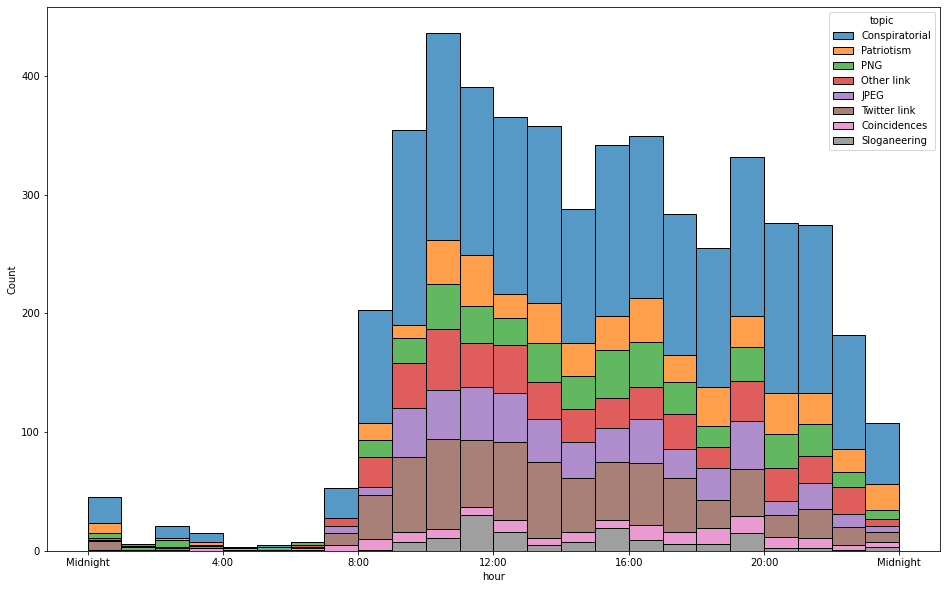

In [2]:
fig = plt.gcf()

fig.set_size_inches(16, 10)

sns.histplot(df, x='hour', binwidth=1, hue='topic', multiple='stack')
p = plt.xticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))

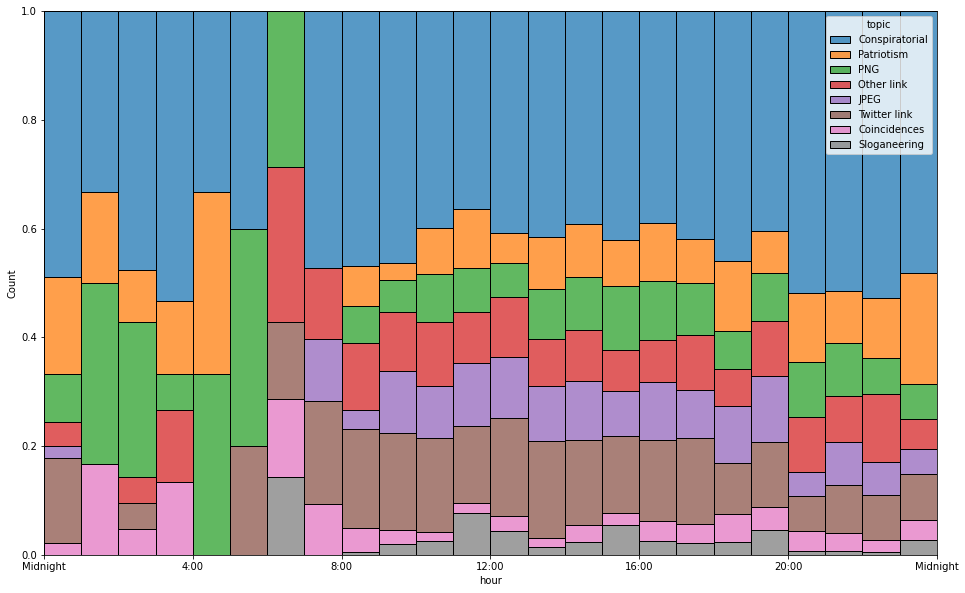

In [3]:
fig = plt.gcf()

fig.set_size_inches(16, 10)

sns.histplot(df, x='hour', binwidth=1, hue='topic', multiple='fill')
p = plt.xticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))

In [4]:
posts_within_1_hr = df[df.minutes_since_last_drop <= 60]
posts_within_6_hrs = df[df.minutes_since_last_drop <= 360]
posts_within_30_mins = df[df.minutes_since_last_drop <= 30]

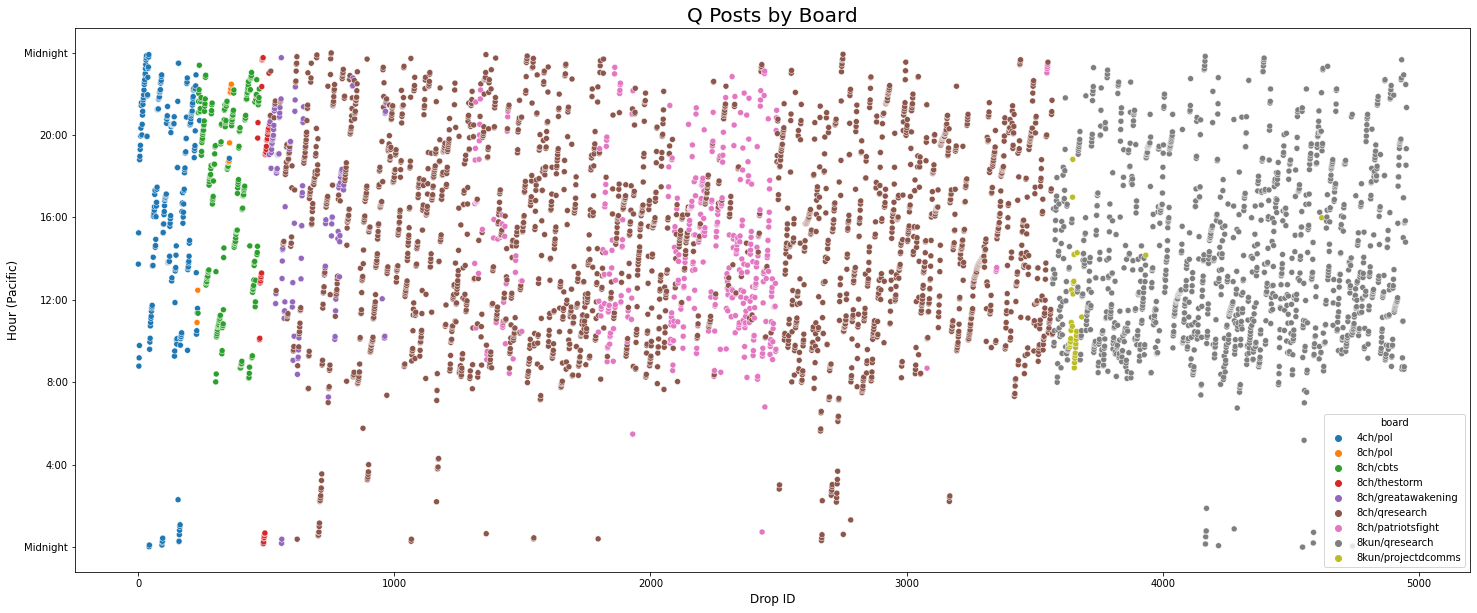

In [5]:
fig = plt.gcf()

# Change seaborn plot size
fig.set_size_inches(25, 10)

sns.scatterplot(data=df, x='drop_id', y='hour', hue='board').set_title('Q Posts by Board', size=20)
p = plt.xlabel("Drop ID", size=12)
p = plt.ylabel("Hour (Pacific)", size=12)
p = plt.yticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=2, stop_words='english')
doc_term_matrix = tfidf_vect.fit_transform(df.body_text.values.astype('U'))

from sklearn.decomposition import NMF

nmf = NMF(n_components=8, random_state=42)
nmf.fit(doc_term_matrix)

for i,topic in enumerate(nmf.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:][::-1]])
    print('\n')

/home/robert/.local/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Top 10 words for topic #0:
['status', 'twitter', 'com', 'https', 'realdonaldtrump', 'vip', 'mobile', 'patriot', 'love', 'cbs_herridge']


Top 10 words for topic #1:
['jpg', 'large', '220px', 'pain', 'anons', 'remember', 'remembering', 'enemy', 'reconcile', 'unknown']


Top 10 words for topic #2:
['png', 'clipboardimage', 'delta', 'screen', 'shot', 'coincidence', 'anon', 'realdonaldtrump', 'united', 'large']


Top 10 words for topic #3:
['youtube', 'watch', 'www', 'https', 'com', 'feature', 'g2qixxafxcq', 'youtu', 'politics', 'html']


Top 10 words for topic #4:
['news', 'potus', 'think', 'people', 'did', 'fake', 'public', 'control', 'fbi', 'www']


Top 10 words for topic #5:
['jpeg', 'coincidence', 'coincidences', 'believe', 'ready', 'patriots', 'game', 'image0', 'news', 'hear']


Top 10 words for topic #6:
['wwg1wga', 'stand', 'united', 'status', 'win', 'wrwy', 'qthewakeup', 'stop', 'twitter', 'great']


Top 10 words for topic #7:
['god', 'patriots', 'bless', 'country', 'stand', 'patr

## My best guess at labeling the above topics:

- 0: Twitter link
- 1: JPEG
- 2: PNG
- 3: Youtube video
- 4: Conspiratorial
- 5: Coincidences
- 6: Sloganeering
- 7: Patriotism


In [7]:
topic_values = nmf.transform(doc_term_matrix)
topics = pd.DataFrame(topic_values)
topics.columns = ['Twitter link', 'JPEG', 'PNG', 'Other link', 'Conspiratorial', 'Coincidences', 'Sloganeering', 'Patriotism']
topics['drop_id'] = topics.index + 1
topics = topics.set_index('drop_id')
topics=((topics-topics.min())/(topics.max()-topics.min()))

In [29]:
df['topic'] = topics.columns[topic_values.argmax(axis=1)]
topic_twitter = df[df.topic == 'Twitter link']
topic_jpeg = df[df.topic == 'JPEG']
topic_png = df[df.topic == 'PNG']
topic_other = df[df.topic == 'Other link']
topic_conspiratorial = df[df.topic == 'Conspiratorial']
topic_coincidences = df[df.topic == 'Coincidences']
topic_sloganeering = df[df.topic == 'Sloganeering']
topic_patriotism = df[df.topic == 'Patriotism']

/home/robert/.local/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


NameError: name 'posts_under_250_chars' is not defined

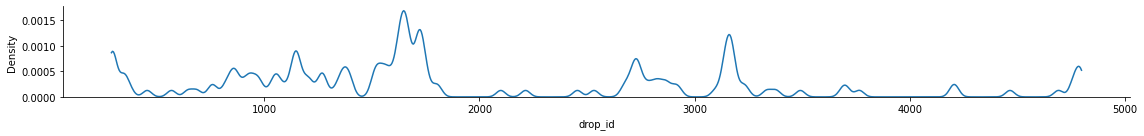

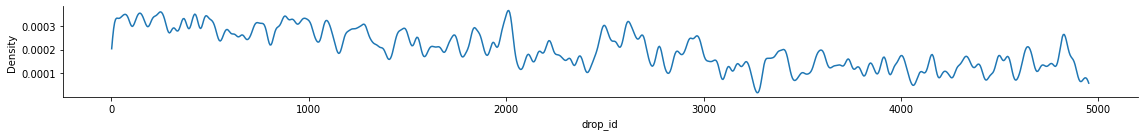

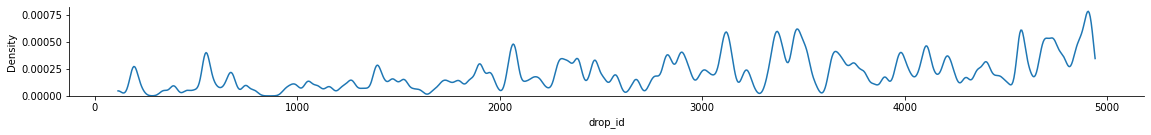

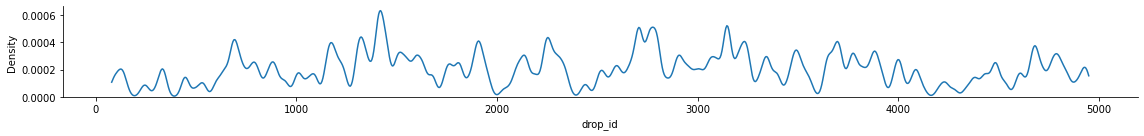

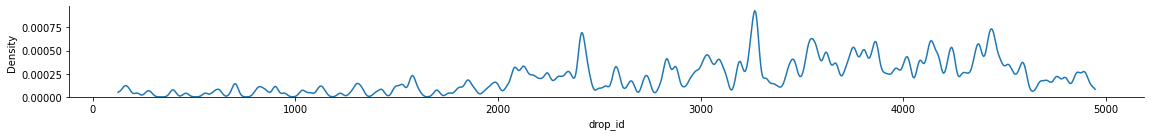

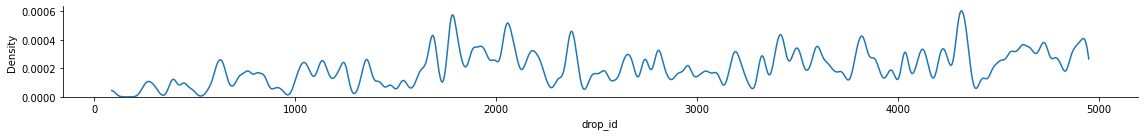

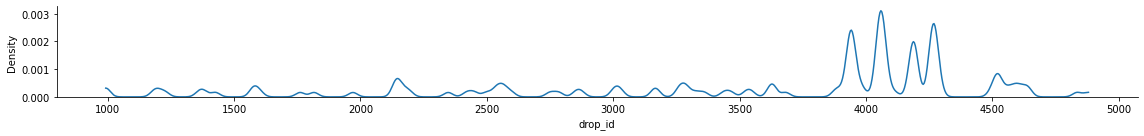

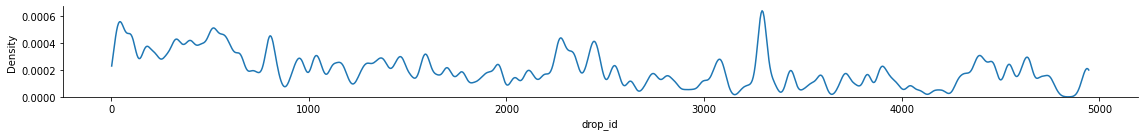

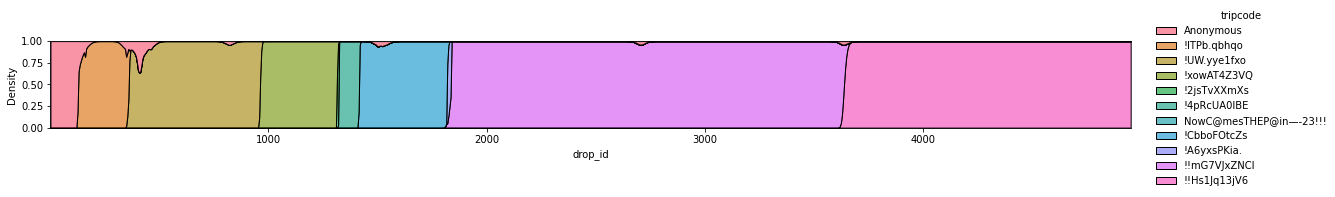

In [10]:
# rolling_avg_topics = topics.rolling(window=150).mean()

sns.displot(topic_coincidences, x='drop_id', hue='topic', kind='kde', height=2, aspect=8, bw_adjust=0.05, gridsize=1000, cut=0, legend=False)
sns.displot(topic_conspiratorial, x='drop_id', hue='topic', kind='kde', height=2, aspect=8, bw_adjust=0.05, gridsize=1000, cut=0, legend=False)
sns.displot(topic_jpeg, x='drop_id', hue='topic', kind='kde', height=2, aspect=8, bw_adjust=0.05, gridsize=1000, cut=0, legend=False)
sns.displot(topic_png, x='drop_id', hue='topic', kind='kde', height=2, aspect=8, bw_adjust=0.05, gridsize=1000, cut=0, legend=False)
sns.displot(topic_twitter, x='drop_id', hue='topic', kind='kde', height=2, aspect=8, bw_adjust=0.05, gridsize=1000, cut=0, legend=False)
sns.displot(topic_other, x='drop_id', hue='topic', kind='kde', height=2, aspect=8, bw_adjust=0.05, gridsize=1000, cut=0, legend=False)
sns.displot(topic_sloganeering, x='drop_id', hue='topic', kind='kde', height=2, aspect=8, bw_adjust=0.05, gridsize=1000, cut=0, legend=False)
sns.displot(topic_patriotism, x='drop_id', hue='topic', kind='kde', height=2, aspect=8, bw_adjust=0.05, gridsize=1000, cut=0, legend=False)

sns.displot(df, x='drop_id', hue='tripcode', multiple='fill', kind='kde', height=2, aspect=8, bw_adjust=0.1, gridsize=1000, cut=0, legend=True)
sns.displot(posts_under_250_chars, x='drop_id', hue='topic', cumulative=False, kind='kde', multiple='fill', height=8, aspect=3, bw_adjust=0.05, gridsize=1000, cut=0, legend=True)

posts_150_to_650 = df[149:650]
sns.displot(posts_150_to_650, x='drop_id', hue='tripcode', multiple='fill', kind='kde', height=2, aspect=8, bw_adjust=0.1, gridsize=1000, cut=0, legend=False)
sns.displot(posts_150_to_650, x='drop_id', hue='topic', kind='kde', multiple='fill', height=8, aspect=3, bw_adjust=0.1, gridsize=1000, cut=0, legend=False)


posts_1750_to_1900 = df[1749:1900]
topic_conspiratorial = posts_1750_to_1900[posts_1750_to_1900.topic == 'Conspiratorial']
sns.displot(posts_1750_to_1900, x='drop_id', hue='tripcode', multiple='fill', kind='kde', height=2, aspect=8, bw_adjust=0.1, gridsize=1000, cut=0, legend=True)
sns.displot(topic_conspiratorial, x='drop_id', hue='topic', kind='kde', height=2, aspect=8, bw_adjust=0.05, gridsize=1000, cut=0, legend=False)
sns.displot(posts_1750_to_1900, x='drop_id', hue='topic', kind='kde', multiple='fill', height=8, aspect=3, bw_adjust=0.1, gridsize=1000, cut=0, legend=True)

posts_3500_to_3800 = df[3499:3800]
topic_conspiratorial = posts_3500_to_3800[posts_3500_to_3800.topic == 'Conspiratorial']
sns.displot(posts_3500_to_3800, x='drop_id', hue='tripcode', multiple='fill', kind='kde', height=2, aspect=8, bw_adjust=0.1, gridsize=1000, cut=0, legend=False)
sns.displot(topic_conspiratorial, x='drop_id', hue='topic', kind='kde', height=2, aspect=8, bw_adjust=0.05, gridsize=1000, cut=0, legend=False)
sns.displot(posts_3500_to_3800, x='drop_id', hue='topic', kind='kde', multiple='fill', height=8, aspect=3, bw_adjust=0.1, gridsize=1000, cut=0, legend=False)

In [11]:
tripcodes = df.tripcode.unique()
total_drops = len(df)

top_8_Qs = []

for tripcode in tripcodes:
    if (len(df[df.tripcode == tripcode]) / total_drops * 100) > 1:
        top_8_Qs.append(tripcode)

for tripcode in top_8_Qs:
    all_posts_by_tripcode = df[df.tripcode == tripcode]
    uppercase_posts = all_posts_by_tripcode[all_posts_by_tripcode.is_uppercase]
    pct_uppercase = len(uppercase_posts) / len(all_posts_by_tripcode)
    print('{0}\t{1:.2%} uppercase'.format(tripcode, pct_uppercase))

Anonymous	1.23% uppercase
!ITPb.qbhqo	2.68% uppercase
!UW.yye1fxo	6.17% uppercase
!xowAT4Z3VQ	3.13% uppercase
!4pRcUA0lBE	1.06% uppercase
!CbboFOtcZs	1.00% uppercase
!!mG7VJxZNCI	3.06% uppercase
!!Hs1Jq13jV6	1.90% uppercase


Text(0, 0.5, 'Board')

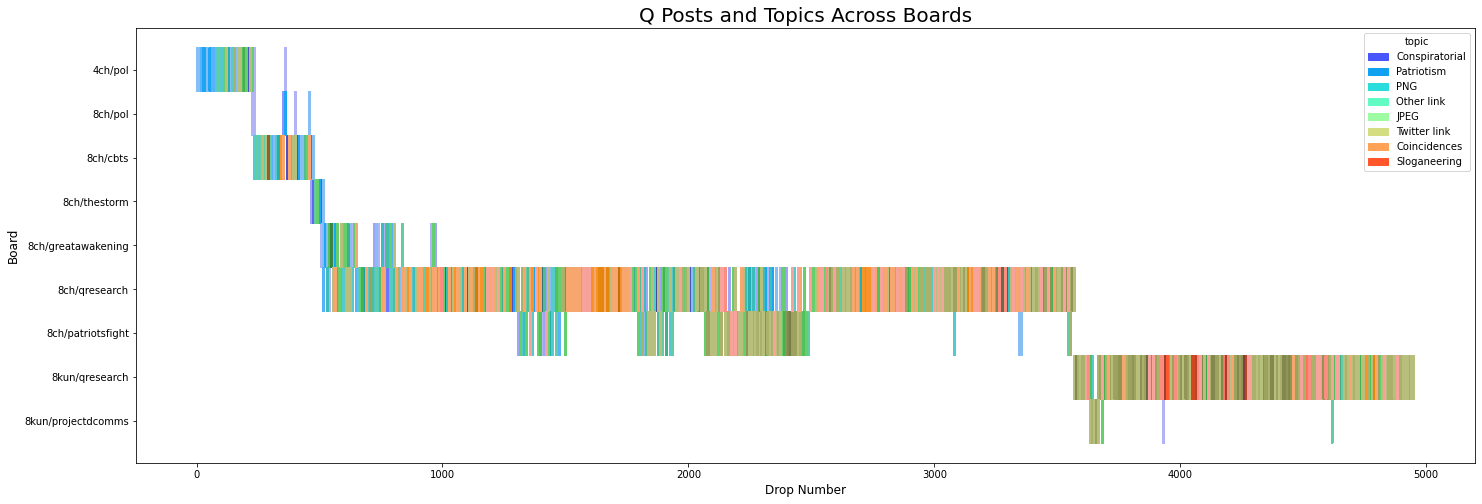

In [12]:
#sns.jointplot(data=df, x='drop_id', y='topic', kind='hist')
sns.color_palette("rainbow", 8)

fig = plt.gcf()
fig.set_size_inches(24, 8)
sns.set_palette("rainbow", 8)
sns.histplot(data=df, x='drop_id', y='board', hue='topic', bins=600).set_title('Q Posts and Topics Across Boards', size=20)

fig.set_size_inches(24, 8)
plt.xlabel("Drop Number", size=12)
plt.ylabel("Board", size=12)



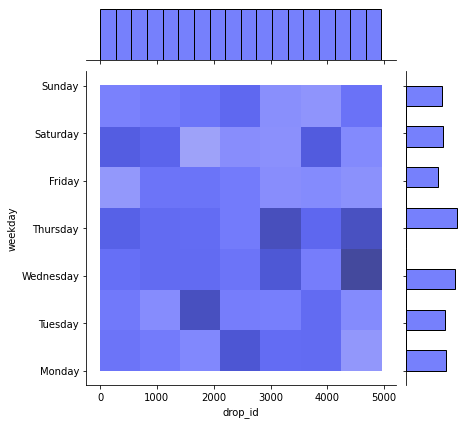

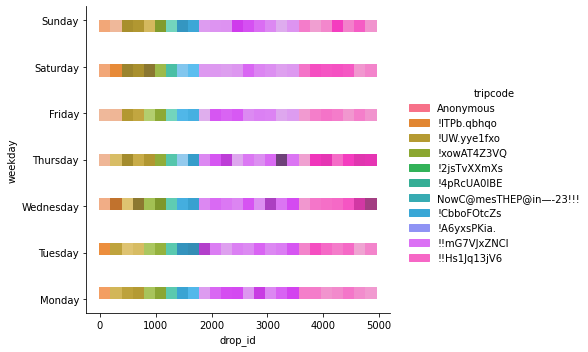

In [14]:
sns.jointplot(data=df, x='drop_id', y='weekday', bins=7, kind='hist')
p = plt.yticks(np.arange(7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))

sns.displot(data=df, x='drop_id', y='weekday', hue='tripcode', bins=25)
p = plt.yticks(np.arange(7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))

In [15]:
q_replies = df[df.is_reply]
q_replies = pd.DataFrame(q_replies)
q_replies

,drop_id,date,tripcode,board,thread,time,hour,hour_utc,time_utc,minutes_since_last_drop,...,body_text,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,1,2017-10-28 13:44:28-07:00,Anonymous,4ch/pol,NaN,13:44:28,13.733333,20.733333,20:44:28,NaN,...,>>147005381 >>146981635 Hillary Clinton will ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,28,2017-10-31 22:59:01-07:00,Anonymous,4ch/pol,NaN,22:59:01,22.983333,5.983333,05:59:01,2.916667,...,>>147450119 Spy.png >>147441102 >What must be...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,51,2017-11-02 11:12:06-07:00,Anonymous,4ch/pol,NaN,11:12:06,11.200000,18.200000,18:12:06,5.133333,...,>>147642589 one-nation-under-god-t-shirt_desi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,58,2017-11-02 13:40:27-07:00,Anonymous,4ch/pol,NaN,13:40:27,13.666667,20.666667,20:40:27,0.816667,...,>>147661217 http://thehill.com/blogs/pundits-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,66,2017-11-02 17:19:28-07:00,Anonymous,4ch/pol,NaN,17:19:28,17.316667,0.316667,00:19:28,12.166667,...,>>147688276 >>147687684 Let's be clear - you'...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4876,4877,2020-10-15 14:33:19-07:00,!!Hs1Jq13jV6,8kun/qresearch,11090367.0,14:33:19,14.550000,21.550000,21:33:19,0.616667,...,>>11090349 Capture.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4877,4878,2020-10-15 14:54:41-07:00,!!Hs1Jq13jV6,8kun/qresearch,11090814.0,14:54:41,14.900000,21.900000,21:54:41,21.366667,...,>>11090593 twitter_over_capacity.jpg Q YOU BR...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4878,4879,2020-10-15 14:56:51-07:00,!!Hs1Jq13jV6,8kun/qresearch,11090880.0,14:56:51,14.933333,21.933333,21:56:51,2.166667,...,>>11090775 ClipboardImage.png https://twitter...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4909,4910,2020-10-21 11:47:34-07:00,!!Hs1Jq13jV6,8kun/qresearch,11192736.0,11:47:34,11.783333,18.783333,18:47:34,3.650000,...,>>11192597 >>11192505 So many people refuse s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
from datetime import datetime
import pytz

tz = pytz.timezone('America/Los_Angeles')

daylight_savings_1 = df[df.date >= datetime.fromisoformat('2019-02-10').astimezone(tz)]
daylight_savings_1 = daylight_savings_1[daylight_savings_1.date <= datetime.fromisoformat('2019-04-10').astimezone(tz)]

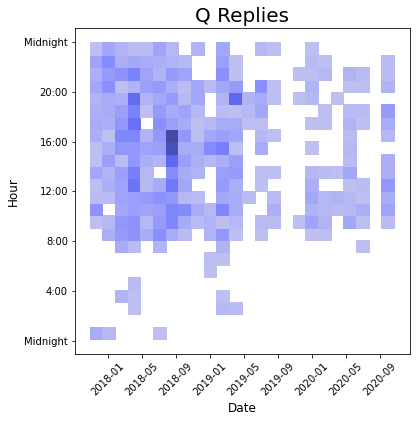

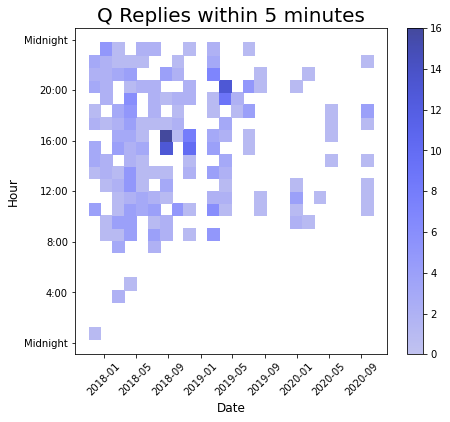

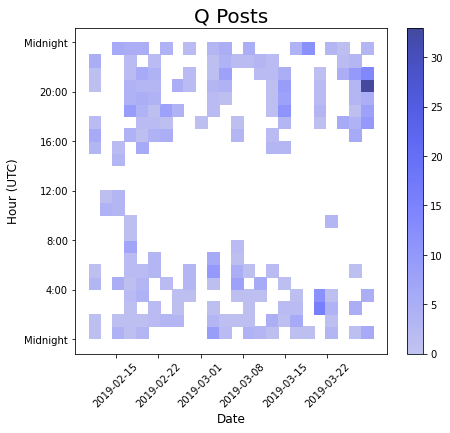

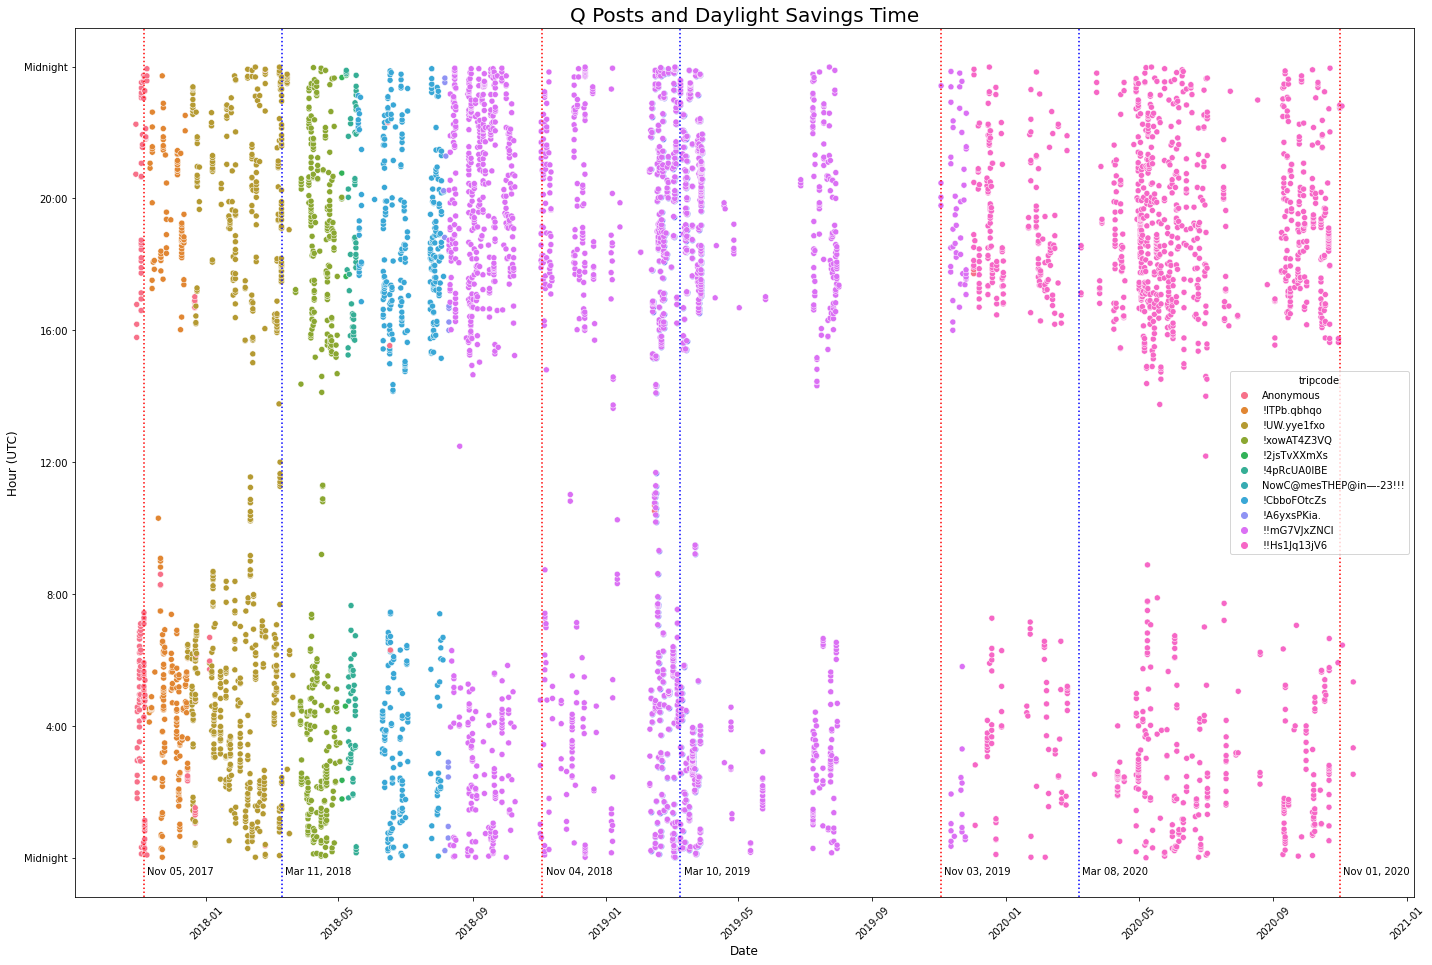

In [17]:
plt.figure(figsize=(6,6))
sns.histplot(data=q_replies, x='date', y='hour', bins=24).set_title('Q Replies', size=20)
plt.xticks(rotation=45)
plt.xlabel("Date", size=12)
plt.ylabel("Hour", size=12)
plt.yticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))
plt.show()

q_replies['minutes_since_last_reply'] = pd.to_datetime(q_replies.date, utc=True).diff().dt.total_seconds() / 60
q_replies_with_30_minutes = q_replies[q_replies['minutes_since_last_reply'] <= 5]

plt.figure(figsize=(7,6))
sns.histplot(data=q_replies_with_30_minutes, x='date', y='hour', bins=24, cbar=True).set_title('Q Replies within 5 minutes', size=20)
plt.xticks(rotation=45)
plt.xlabel("Date", size=12)
plt.ylabel("Hour", size=12)
plt.yticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))
plt.show()

plt.figure(figsize=(7,6))
sns.histplot(data=daylight_savings_1, x='date', y='hour_utc', bins=24, cbar=True).set_title('Q Posts', size=20)
plt.xticks(rotation=45)
plt.xlabel("Date", size=12)
plt.ylabel("Hour (UTC)", size=12)
plt.yticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))
plt.show()

fig = plt.gcf()

# Change seaborn plot size
fig.set_size_inches(12, 12)
plt.xticks(rotation=45)

sns.scatterplot(data=daylight_savings_1, x='date', y='hour_utc').set_title('Q Posts, 2/10 2019 through 4/10 2019', size=20)
plt.xlabel("Date", size=12)
plt.ylabel("Hour (UTC)", size=12)
plt.yticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))

fig = plt.gcf()

# Change seaborn plot size
fig.set_size_inches(24, 16)
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))

sns.scatterplot(data=df, x='date', y='hour_utc', hue='tripcode').set_title('Q Posts and Daylight Savings Time', size=20)
plt.xlabel("Date", size=12)
plt.ylabel("Hour (UTC)", size=12)
plt.yticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))

dst_dates = [
    datetime.fromisoformat('2017-11-05'),
    datetime.fromisoformat('2018-03-11'),
    datetime.fromisoformat('2018-11-04'),
    datetime.fromisoformat('2019-03-10'),
    datetime.fromisoformat('2019-11-03'),
    datetime.fromisoformat('2020-03-08'),
    datetime.fromisoformat('2020-11-01')
]

color = 'red'

from datetime import timedelta

for dst in dst_dates:
    plt.axvline(x=dst, ls=':', color=color)
    plt.text(x = dst + timedelta(days=3), y = -0.5, s = dst.strftime("%b %d, %Y"))
    if color == 'red':
        color = 'blue'
    else:
        color = 'red'
    

In [18]:
# First drop on 8ch: #230
print(df[df.board.str.startswith('8ch')].iloc[0])

# First drop on 8kun: #3571
print(df[df.board.str.startswith('8kun')].iloc[0])

# First drop w/ tripcode !Cbb... #1417
print(df[df.tripcode.str.startswith('!Cbb')].iloc[0])

drop_id                                                                      230
date                                                   2017-11-25 10:54:45-08:00
tripcode                                                             !ITPb.qbhqo
board                                                                    8ch/pol
thread                                                                       NaN
time                                                                    10:54:45
hour                                                                   10.900000
hour_utc                                                               18.900000
time_utc                                                                18:54:45
minutes_since_last_drop                                                23.966667
minutes_since_last_drop_avg                                           438.313333
post_length_chars                                                             67
weekday                     

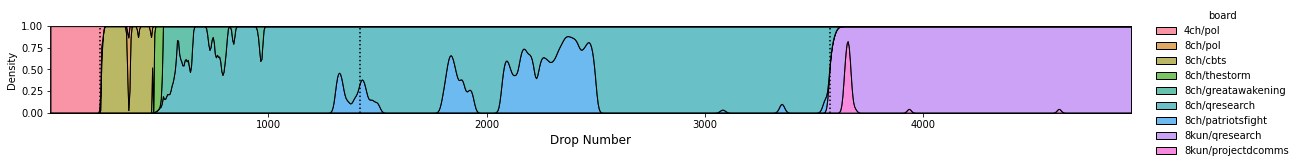

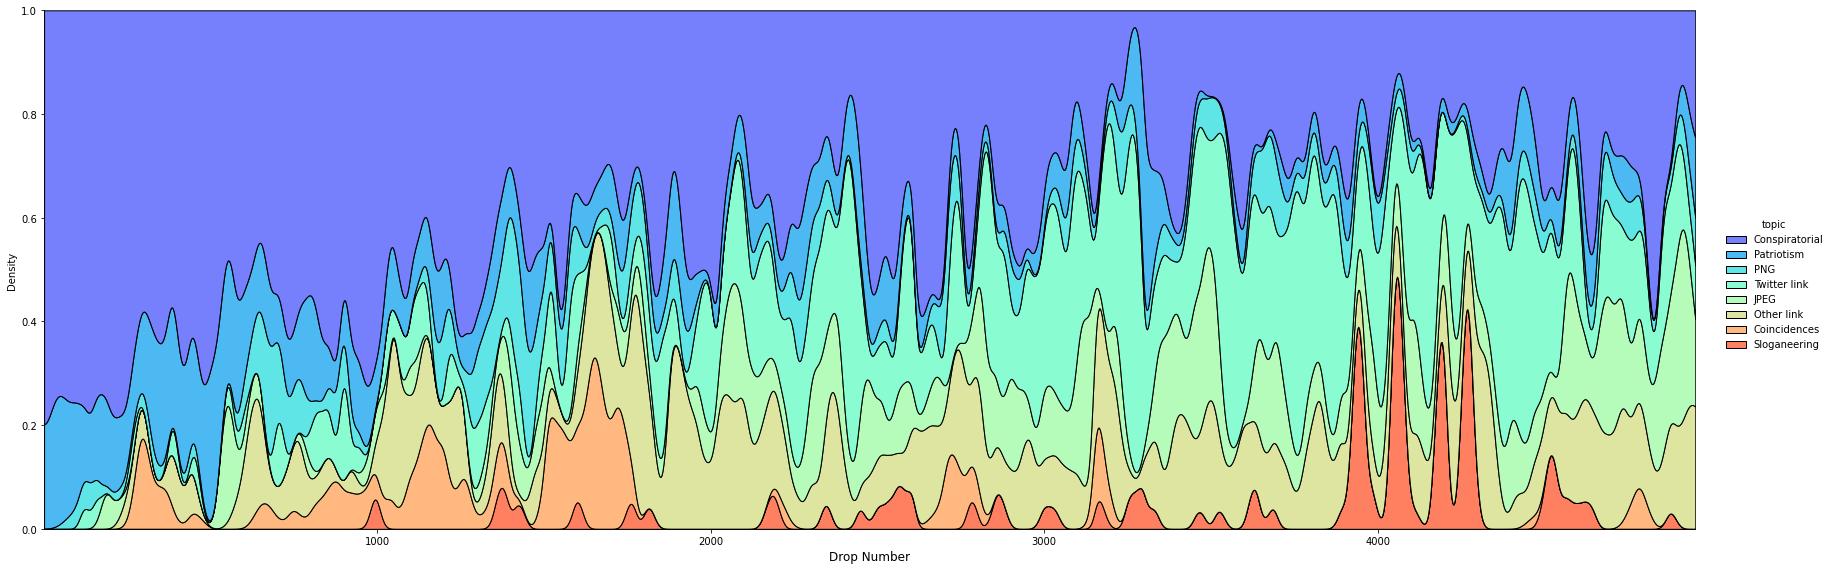

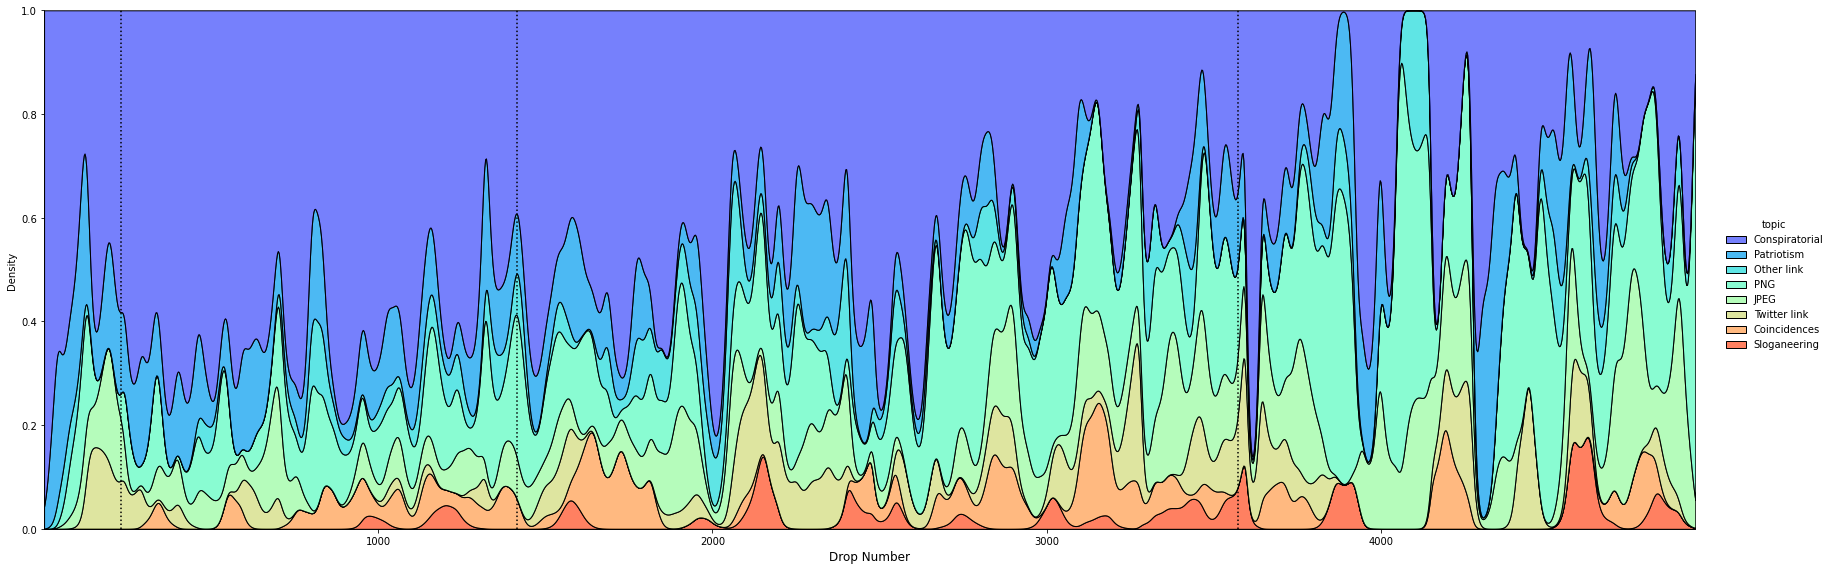

In [19]:
sns.displot(df, x='drop_id', hue='board', multiple='fill', kind='kde', height=2, aspect=8, bw_adjust=0.1, gridsize=1000, cut=0, legend=True)
plt.xlabel("Drop Number", size=12)

plt.axvline(x=230, ls=':', color='black')
plt.axvline(x=1417, ls=':', color='black')
plt.axvline(x=3571, ls=':', color='black')

non_replies = df[df.is_reply == False]

sns.displot(non_replies, x='drop_id', hue='topic', cumulative=False, kind='kde', multiple='fill', height=8, aspect=3, bw_adjust=0.05, gridsize=2000, cut=0, legend=True)
plt.xlabel("Drop Number", size=12)

sns.displot(q_replies, x='drop_id', hue='topic', cumulative=False, kind='kde', multiple='fill', height=8, aspect=3, bw_adjust=0.05, gridsize=2000, cut=0, legend=True)
plt.xlabel("Drop Number", size=12)

plt.axvline(x=230, ls=':', color='black')
plt.axvline(x=1417, ls=':', color='black')
plt.axvline(x=3571, ls=':', color='black')

<ipython-input-20-9680a6600840>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  posts_3250_to_3750 = df[df.drop_id >= 3250][df.drop_id <= 3750]


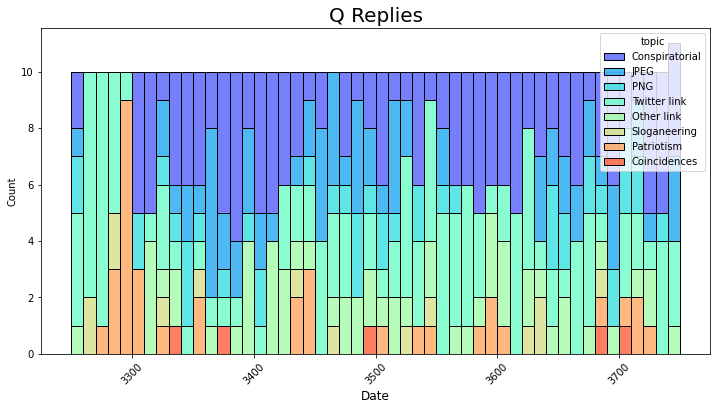

In [20]:
plt.figure(figsize=(12,6))
posts_3250_to_3750 = df[df.drop_id >= 3250][df.drop_id <= 3750]
sns.histplot(data=posts_3250_to_3750, x='drop_id', hue='topic', multiple='stack', bins=50).set_title('Q Replies', size=20)
plt.xticks(rotation=45)
plt.xlabel("Date", size=12)
plt.show()

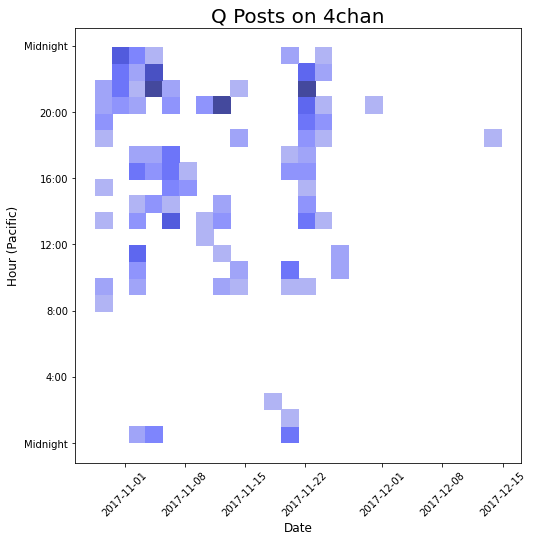

In [21]:
fch_posts = df[df.board.str.startswith('4ch')]

fig = plt.gcf()
fig.set_size_inches(8, 8)
p = plt.xticks(rotation=45)

sns.histplot(data=fch_posts, x='date', y='hour', bins=24).set_title('Q Posts on 4chan', size=20)
p = plt.xlabel("Date", size=12)
p = plt.ylabel("Hour (Pacific)", size=12)
p = plt.yticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))

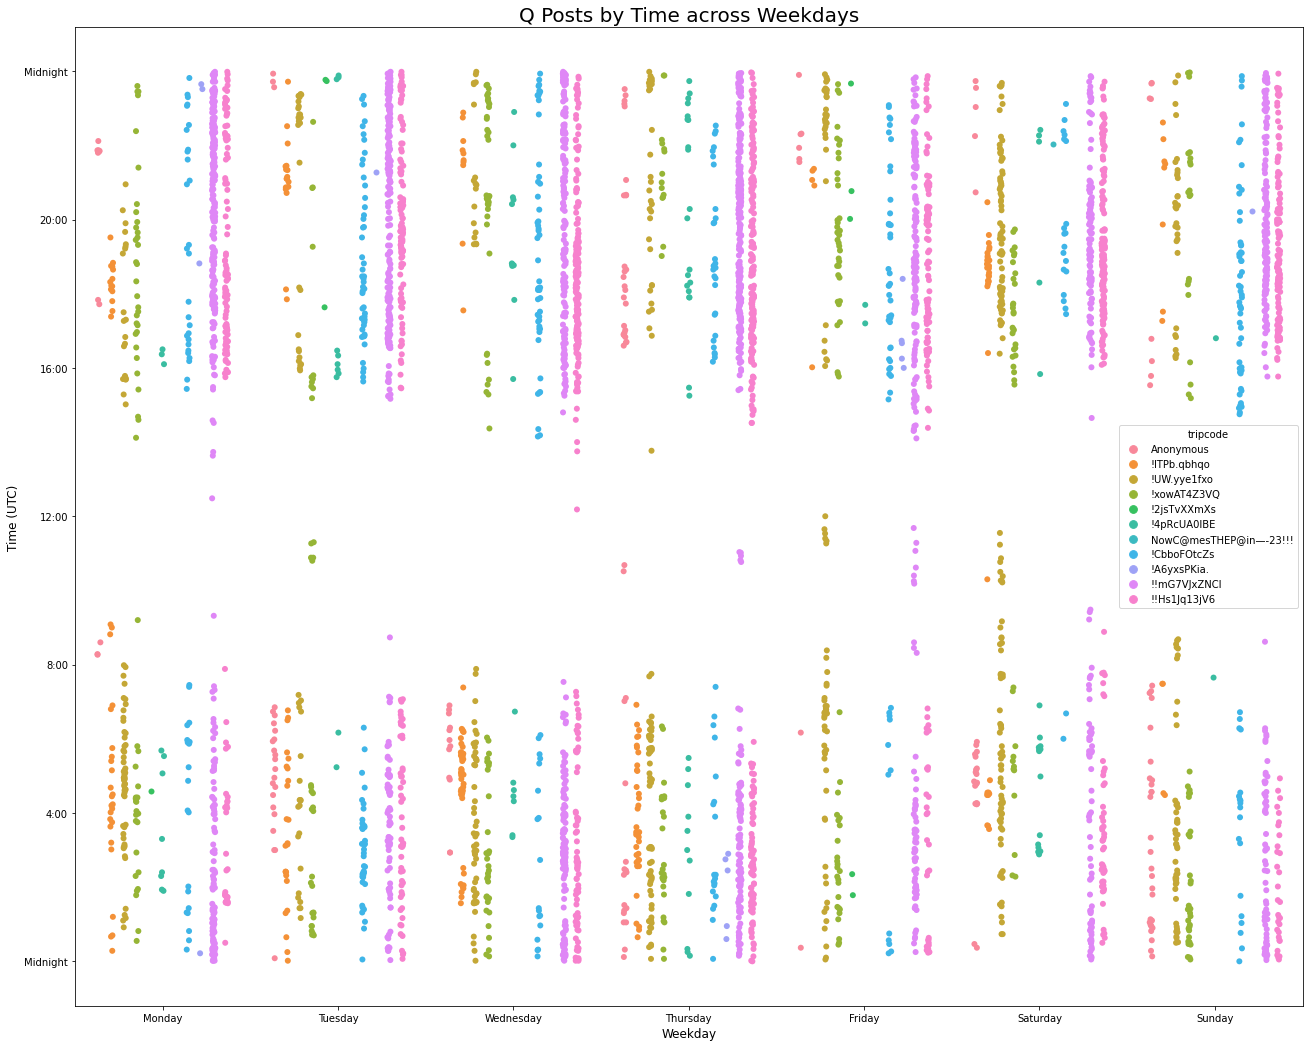

In [63]:
# weekdays = df.replace({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})
fig = plt.gcf()
fig.set_size_inches(22, 18)

sns.stripplot(x="weekday", y="hour_utc", data=df, hue="tripcode", dodge=True, size=6)\
    .set_title('Q Posts by Time across Weekdays', size=20)

p = plt.xlabel("Weekday", size=12)
p = plt.ylabel("Time (UTC)", size=12)

p = plt.xticks(np.arange(7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
p = plt.yticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))


In [49]:
df['platform'] = df.board.str.split('/', expand=False)
df['platform'] = df.board.str.split('/', expand=True)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.platform

0        4ch
1        4ch
2        4ch
3        4ch
4        4ch
        ... 
4947    8kun
4948    8kun
4949    8kun
4950    8kun
4951    8kun
Name: platform, Length: 4952, dtype: object

/home/robert/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


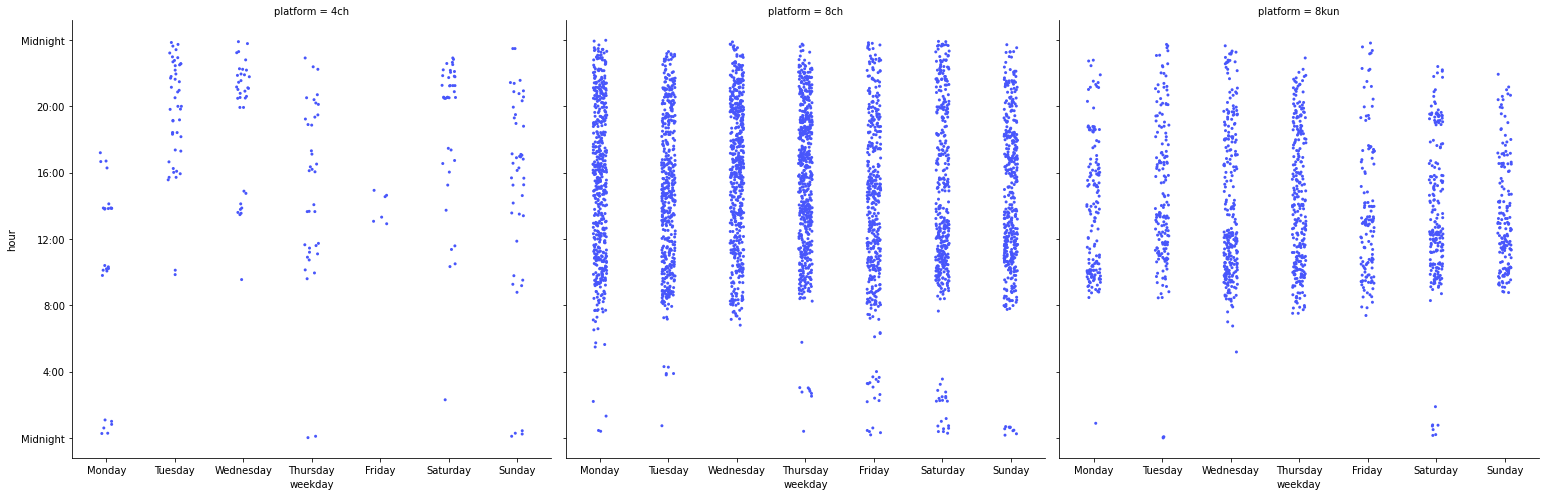

In [64]:
g = sns.FacetGrid(df, col="platform", col_wrap=4, height=7)
g.map(sns.stripplot, "weekday", "hour", size=3)

plt.xticks(np.arange(7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
p = plt.yticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))

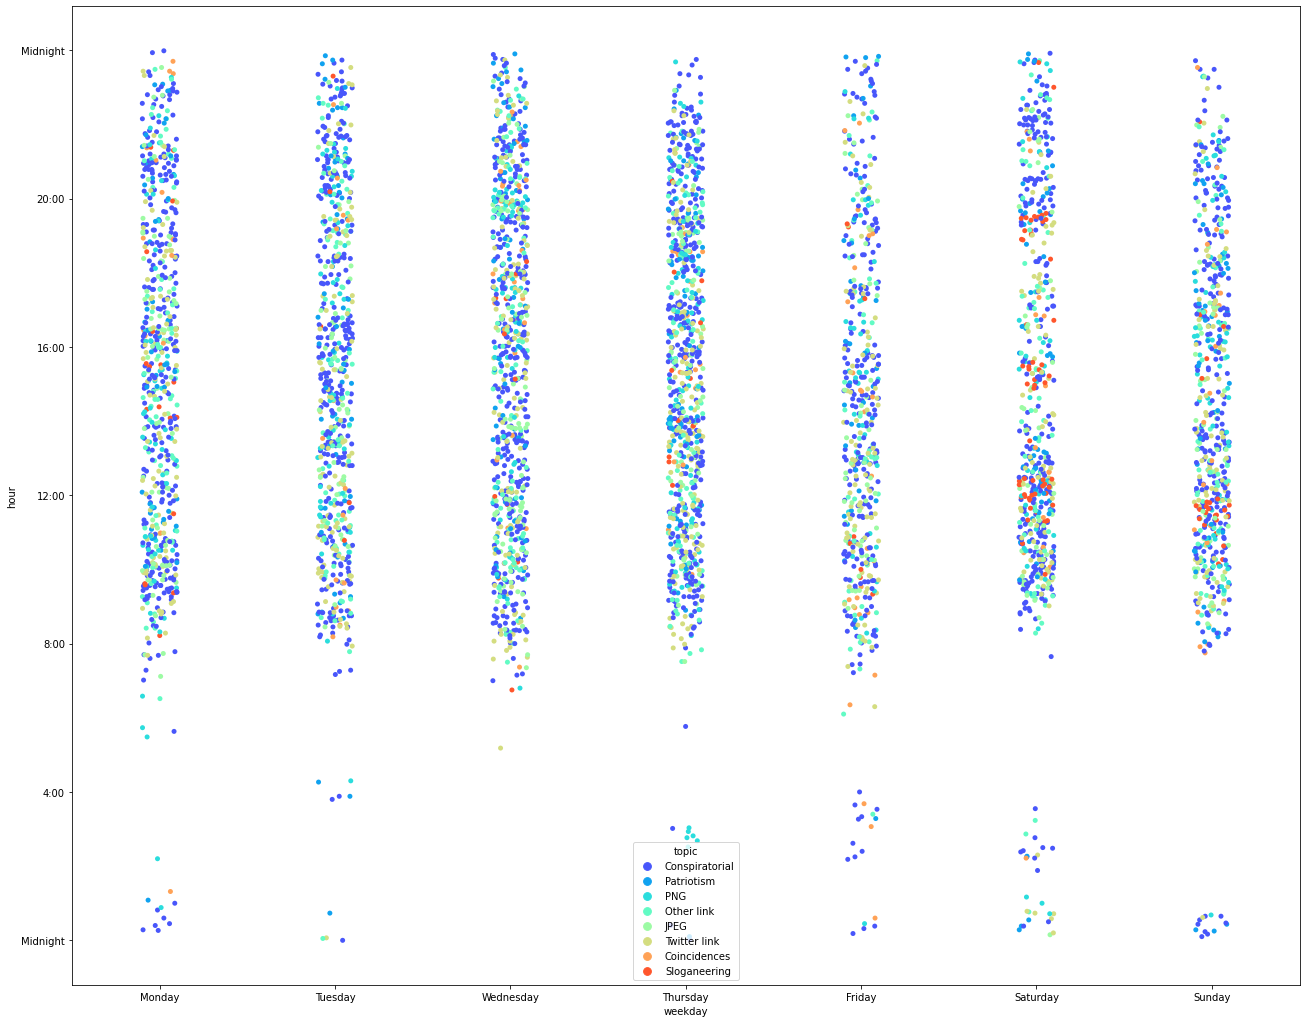

In [65]:
fig = plt.gcf()
fig.set_size_inches(22, 18)

sns.stripplot(data=df, x="weekday", y="hour", size=5, hue='topic')

plt.xticks(np.arange(7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
p = plt.yticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))

<AxesSubplot:xlabel='drop_id', ylabel='Count'>

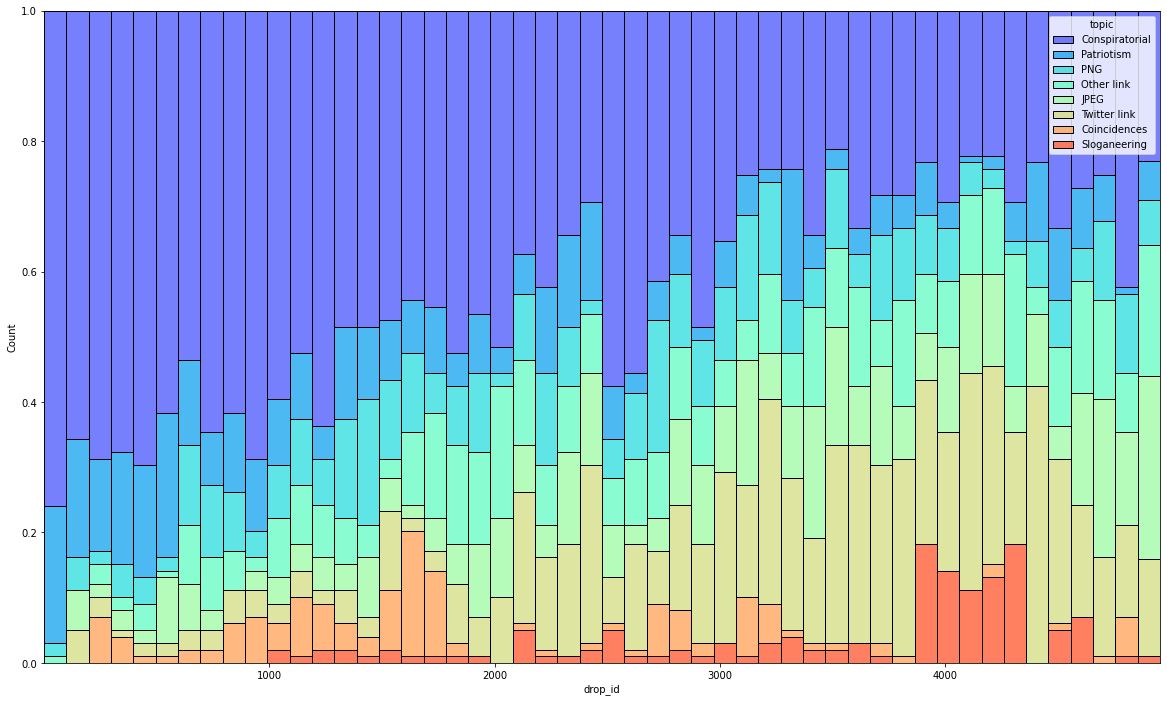

In [58]:
fig = plt.gcf()
fig.set_size_inches(20, 12)

# drops_150_to_300_c =  df.drop_id > 150
# drops_150_to_300_c &= df.drop_id < 300
# drops_150_to_300 = df[drops_150_to_300_c]

sns.histplot(data=df, x='drop_id', bins=50, hue='topic', multiple='fill')

In [105]:
search_drops('Matlock')

Found 2 matches. 

[2018-01-03 21:43:04-08:00] Drop #460: 

  [J-Go_dX)-2-8 Everything has meaning. Who is AMB Matlock? YES. /[ RR -out][P_pers] EO_CLASSIFIED_WH[ -6713A] SIG_con_MAR39sv3665BECD Q 
 

[2018-01-06 10:04:06-08:00] Drop #474: 

  THEY Divide. WE Conquer. Anticipated – human nature. Anticipated – interruptions by others. Matlock meant to become PUBLIC. THIS IS NOT A GAME. CM – thank you for IDEN verification. CM – how can a secure ‘read only’ board be set up whereby the message can be safely delivered? If a board was created, you verified IDEN, and control was w/ you/us, that would eliminate confusion as to IDEN/AUTH correct? No mod management – only info dumps. Fact-finding, archiving, discussion, etc. can then be done on a designated ‘follow up’ board. Message is all that matters. THE GREAT AWAKENING. Time is severely limited. Q 
 

